<a href="https://colab.research.google.com/github/amansyayf/PhotorealisticStyleTransfer/blob/main/notebooks/testing_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19

from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import os
import sys

In [2]:
! wget https://raw.githubusercontent.com/amansyayf/PhotorealisticStyleTransfer/main/notebooks/models.ipynb

--2023-07-19 13:50:28--  https://raw.githubusercontent.com/amansyayf/PhotorealisticStyleTransfer/main/notebooks/models.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9725 (9.5K) [text/plain]
Saving to: ‘models.ipynb’

models.ipynb        100%[===================>]   9.50K  --.-KB/s    in 0s      

2023-07-19 13:50:28 (94.3 MB/s) - ‘models.ipynb’ saved [9725/9725]



In [3]:
%run models.ipynb

In [6]:
# Dummy class to model get_parser
class Args:
    def __init__(self):
        self.img_root = '/content/drive/MyDrive/images'
        self.content_img = '/content/drive/MyDrive/images/door.png'
        self.style_img = '/content/drive/MyDrive/images/starry_night.png'
        self.use_gpu = True

args = Args()

In [23]:
if args.use_gpu:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        raise Exception('GPU is not available')
else:
    device = torch.device('cpu')

# Load VGG19 features
vgg = vgg19(pretrained=True).features
vgg = vgg.to(device)
# We don't want to train VGG
for param in vgg.parameters():
    param.requires_grad_(False)

# Load style net HRNe
style_net = HRNet()
style_net = style_net.to(device)

torch.backends.cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
device

device(type='cuda')

In [8]:
# Load images
content_img = image_loading(os.path.join(args.img_root, args.content_img), size=500)
content_img = content_img.to(device)

style_img = image_loading(os.path.join(args.img_root, args.style_img), size = 500)
style_img = style_img.to(device)

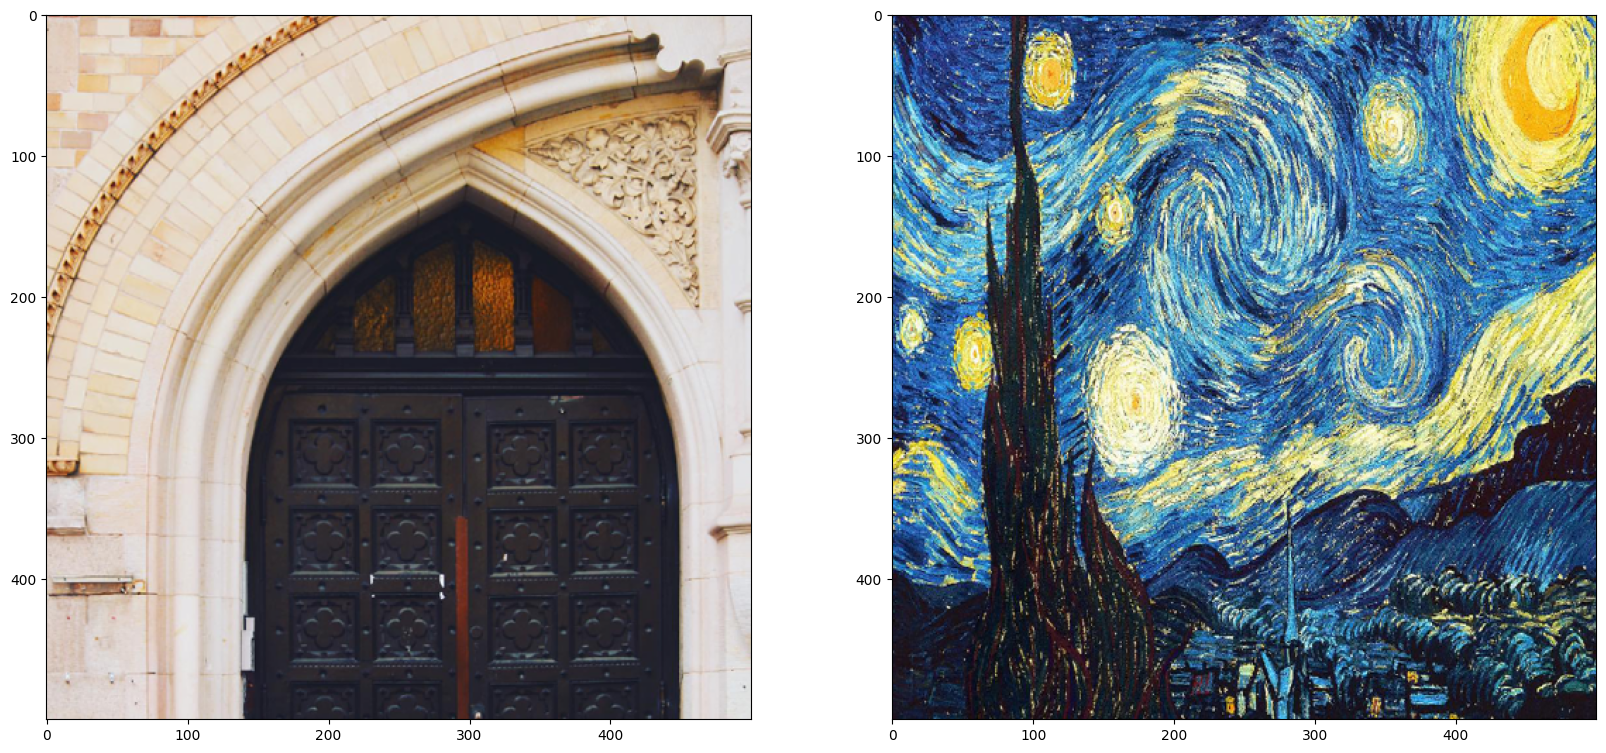

In [9]:
# Show content and style image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content_img))
ax2.imshow(im_convert(style_img))
plt.show()

In [10]:
# Get features from VGG19
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

style_gram_matrixs = {layer: get_gram_matrix(style_features[layer]) for layer in style_features}

target = content_img.clone().requires_grad_(True).to(device)

In [45]:
style_weights = {
     'conv1_1': 0.1,
     'conv2_1': 0.2,
     'conv3_1': 0.4,
     'conv4_1': 0.8,
     'conv5_1': 1.6
}

content_weight = 400
style_weight = 0.2

show_every = 100
optim = torch.optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=200, gamma=0.9)
steps = 400

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_img

In [46]:
style_net1 = HRNet1()
style_net1 = style_net1.to(device)

  0%|          | 0/401 [00:00<?, ?it/s]

After 0 criterions:
Total loss:  3294.04736328125
Content loss:  7.34830904006958
Style loss:  1773.61865234375


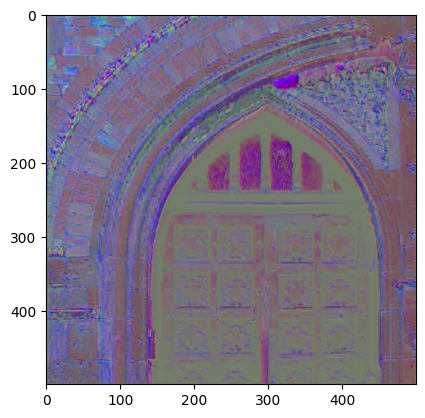

 25%|██▍       | 100/401 [00:14<00:42,  7.05it/s]

After 100 criterions:
Total loss:  3294.04736328125
Content loss:  7.34830904006958
Style loss:  1773.61865234375


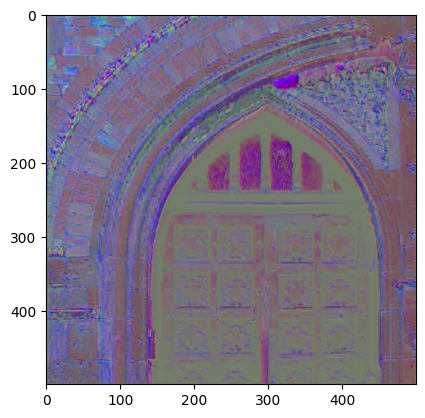

 50%|████▉     | 200/401 [00:29<00:28,  7.00it/s]

After 200 criterions:
Total loss:  3294.04736328125
Content loss:  7.34830904006958
Style loss:  1773.61865234375


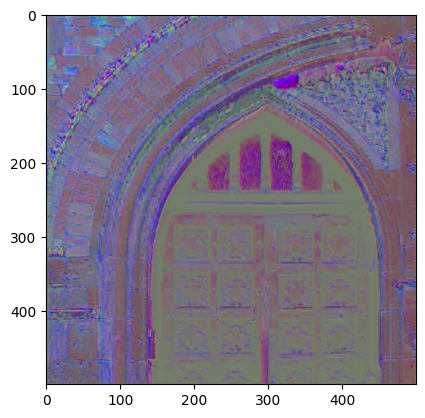

 75%|███████▍  | 300/401 [00:43<00:14,  6.95it/s]

After 300 criterions:
Total loss:  3294.04736328125
Content loss:  7.34830904006958
Style loss:  1773.61865234375


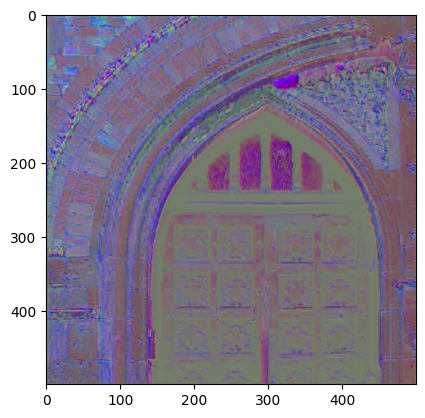

100%|█████████▉| 400/401 [00:58<00:00,  6.94it/s]

After 400 criterions:
Total loss:  3294.04736328125
Content loss:  7.34830904006958
Style loss:  1773.61865234375


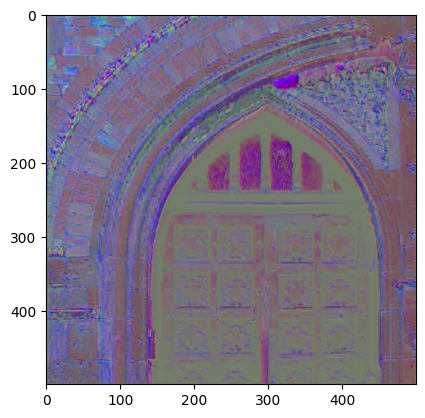

100%|██████████| 401/401 [00:59<00:00,  6.79it/s]


In [47]:
for epoch in tqdm(range(0, steps+1)):
    scheduler.step()

    target = style_net1(content_img).to(device)
    target.requires_grad_(True)

    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0

    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram_matrix = get_gram_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c*h*w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss_epoch.append(total_loss.item())

    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss.item())

    optim.zero_grad()
    total_loss.backward()
    optim.step()

    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

    output_image = target